In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 

In [5]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    cv2.namedWindow("opencv feed", cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty("opencv feed", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    while cap.isOpened():
        ret,frame= cap.read()
        image,results = mediapipe_detection(frame,holistic)
        print(results)
        draw_landmarks(image,results)
        cv2.imshow("opencv feed",frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

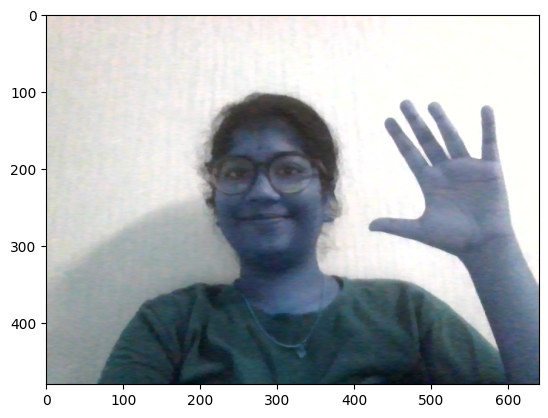

In [7]:
plt.imshow(frame)

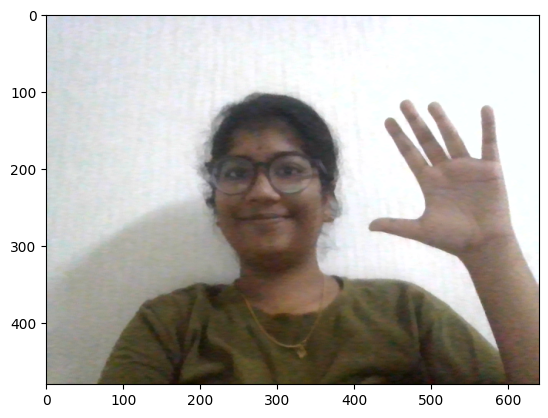

In [8]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

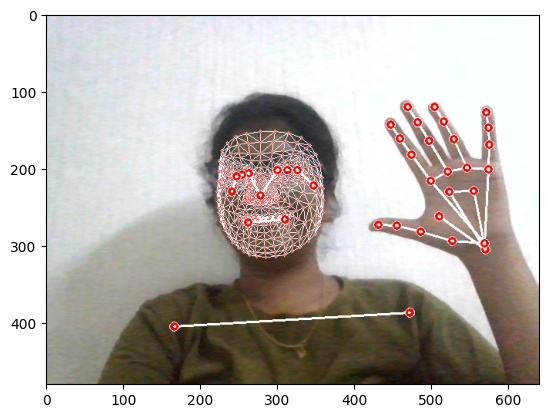

In [9]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [24]:
aks=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
fks=np.array([[res.x,res.y,res.z,res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
lks=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rks=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [30]:
aks.shape

(132,)

In [26]:
lks.shape

(63,)

In [27]:
rks.shape

(63,)

In [28]:
fks.shape

(1872,)